In [12]:
import sys, os, glob
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

sys.path.append('../src/')
from training import train_spotwise, train_gridwise
from count_datasets import load_count_dataset, load_count_grid_dataset, read_annotated_starray
from count_datasets import CountDataset, CountGridDataset, pseudo_hex_to_oddr
from gridnet_models import GridNetHexOddr
from utils import all_fgd_predictions
from plotting import performance_curves

In [6]:
# First, pre-compute and save the output of spot-wise prediction using PCs:

# Build dataset using all tissues
data_dir = os.path.expanduser('~/Documents/Splotch_projects/Maynard_DLPFC/data/')

train_tissues = ['151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674']
val_tissues = ['151675', '151676']
all_tissues = train_tissues + val_tissues

pcafiles = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs_PCs.tsv') % s for s in all_tissues]
annotfiles = [os.path.join(data_dir, 'Covariates_Visium/%s.tsv') % s for s in all_tissues]

spots_pca = load_count_grid_dataset(pcafiles, annotfiles)

# Load pretrained model operating on count PCs
spot_clf_pca = nn.Sequential(
    nn.Linear(2150, 500),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    
    nn.Linear(100, 100),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    
    nn.Linear(50, 7)
)
    
H_VISIUM = 78
W_VISIUM = 64
NUM_PCS = 2150
gnet_pca = GridNetHexOddr(spot_clf_pca, (NUM_PCS,), (H_VISIUM, W_VISIUM), n_classes=7, use_bn=False)

best_parameters = '../models/gnet_pca.pth'
if torch.cuda.is_available():
    gnet_pca.load_state_dict(torch.load(best_parameters))
else:
    gnet_pca.load_state_dict(torch.load(best_parameters, map_location=torch.device('cpu')))

gnet_pca.eval()

GridNetHexOddr(
  (patch_classifier): Sequential(
    (0): Linear(in_features=2150, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=100, bias=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=50, bias=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=7, bias=True)
  )
  (corrector): Sequential(
    (0): Conv2d(7, 32, kernel_size=1, stride=1)
    (1): Conv2d(32, 32, kernel_size=1, stride=1)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=1, stride=1)
    (4): Conv2d(32, 32, kernel_size=1, stride=1)
    (5): ReLU()
    (6): Conv2d(32, 7, kernel_size=1, stride=1)
  )
)

In [7]:
# Compute logits from spot-wise prediction and save results
for i, tissue_id in enumerate(all_tissues):
    x, y = spots_pca[i]
    x = torch.unsqueeze(x, 0)
    
    with torch.no_grad():
        outputs = gnet_pca.patch_predictions(x)
    
    logits = outputs[0].data.numpy()
    np.save('../outputs/maynard_pcapred_maps/maynard_%s_logits_oddr' % tissue_id, logits)

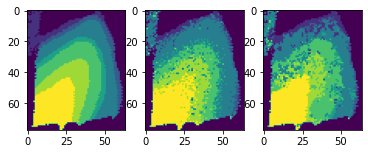

In [8]:
# Next, define a custom Dataset class that takes paired logit maps from spot-wise prediction on images, counts
# and concatenates them into a single model input.
class ConcatDataset(Dataset):
    def __init__(self, logits1, logits2, annot_files):
        super(ConcatDataset, self).__init__()
        
        if not len(logits1)==len(logits1) or not len(logits1)==len(annot_files):
            raise ValueError('Number of logit files and annot files must match.')
        
        self.logits1 = logits1
        self.logits2 = logits2
        self.annot_files = annot_files
    
    def __len__(self):
        return len(self.logits1)
    
    def __getitem__(self, idx):
        f1 = np.load(self.logits1[idx])
        f2 = np.load(self.logits2[idx])
        feat_grid = torch.tensor(np.concatenate((f1, f2), axis=0))
        
        annot_grid = torch.zeros(feat_grid.shape[1:])
        
        amat = pd.read_csv(self.annot_files[idx], header=0, index_col=0, sep='\t')
        for cstr in amat.columns:
            x_vis, y_vis = map(int, cstr.split('_'))
            x, y = pseudo_hex_to_oddr(x_vis, y_vis)
            
            if np.sum(amat[cstr].values) > 0:
                annot_grid[y,x] = np.argmax(amat[cstr].values) + 1
        
        return feat_grid.float(), annot_grid.long()
        
    
count_logits_train = ['../outputs/maynard_pcapred_maps/maynard_%s_logits_oddr.npy' % t for t in train_tissues]
img_logits_train = ['../outputs/maynard_imgpred_maps/maynard_%s_logits_oddr.npy' % t for t in train_tissues]
annots_train = [os.path.join(data_dir, 'Covariates_Visium/%s.tsv') % t for t in train_tissues]

count_logits_val = ['../outputs/maynard_pcapred_maps/maynard_%s_logits_oddr.npy' % t for t in val_tissues]
img_logits_val = ['../outputs/maynard_imgpred_maps/maynard_%s_logits_oddr.npy' % t for t in val_tissues]
annots_val = [os.path.join(data_dir, 'Covariates_Visium/%s.tsv') % t for t in val_tissues]

df = pd.read_csv(annots_train[0], header=0, index_col=0, sep='\t')
annot_names = list(df.index.values)
N_CLASSES = len(annot_names)

train_set = ConcatDataset(count_logits_train, img_logits_train, annots_train)
val_set = ConcatDataset(count_logits_val, img_logits_val, annots_val)

x, y = val_set[0]

pca_preds = x[:N_CLASSES, :, :].data.numpy().argmax(axis=0) + 1
pca_preds[y==0] = 0

img_preds = x[N_CLASSES:, :, :].data.numpy().argmax(axis=0) + 1
img_preds[y==0] = 0

fig, ax = plt.subplots(1,3)
ax[0].imshow(y.data.numpy(), vmin=0, vmax=N_CLASSES)
ax[1].imshow(pca_preds, vmin=0, vmax=N_CLASSES)
ax[2].imshow(img_preds, vmin=0, vmax=N_CLASSES)
plt.show()

In [10]:
# Finally, define a g-network operating on ConcatDataset and train
class GridNetHexConcat(GridNetHexOddr):
    def __init__(self, concat_dim, grid_shape, n_classes):
        self.concat_dim = concat_dim
        
        pc = nn.Linear(1,1)
        super(GridNetHexConcat, self).__init__(pc, (concat_dim,), grid_shape, n_classes, 
                                         use_bn=False, atonce_patch_limit=None)
            
    def _init_corrector(self):
        cnn_layers = []
        cnn_layers.append(nn.Conv2d(self.concat_dim, self.concat_dim, 3, padding=1))
        cnn_layers.append(nn.ReLU())
        
        cnn_layers.append(nn.Conv2d(self.concat_dim, self.concat_dim, 5, padding=2))
        cnn_layers.append(nn.ReLU())
        
        cnn_layers.append(nn.Conv2d(self.concat_dim, self.concat_dim, 5, padding=2))
        cnn_layers.append(nn.ReLU())
        
        cnn_layers.append(nn.Conv2d(self.concat_dim, self.n_classes, 3, padding=1))
        return nn.Sequential(*cnn_layers)
    
    def patch_predictions(self, x):
        return x

gnet_concat = GridNetHexConcat(2*N_CLASSES, (H_VISIUM, W_VISIUM), n_classes=N_CLASSES)
    
dataloader = {
    'train': DataLoader(train_set, batch_size=1, shuffle=True),
    'val': DataLoader(val_set, batch_size=1)
}

loss = nn.CrossEntropyLoss()

# Only optimize the parameters in the g-network
optimizer = torch.optim.Adam(gnet_concat.corrector.parameters(), lr=1e-3)

gnet_concat, val_hist, train_hist = train_gridwise(gnet_concat, dataloader, loss, optimizer, num_epochs=100,
                                    outfile='../models/gnet_concat.pth')

Epoch 0/99
----------
train Loss: 1.5181 Acc: 0.4631
val Loss: 1.4631 Acc: 0.5721

Epoch 1/99
----------
train Loss: 0.8213 Acc: 0.7595
val Loss: 0.7543 Acc: 0.7123

Epoch 2/99
----------
train Loss: 0.4628 Acc: 0.8241
val Loss: 0.7279 Acc: 0.7197

Epoch 3/99
----------
train Loss: 0.4188 Acc: 0.8346
val Loss: 0.7242 Acc: 0.7259

Epoch 4/99
----------
train Loss: 0.3482 Acc: 0.8583
val Loss: 0.5539 Acc: 0.7773

Epoch 5/99
----------
train Loss: 0.2863 Acc: 0.8802
val Loss: 0.5922 Acc: 0.7572

Epoch 6/99
----------
train Loss: 0.2597 Acc: 0.8920
val Loss: 0.5201 Acc: 0.7875

Epoch 7/99
----------
train Loss: 0.2492 Acc: 0.8967
val Loss: 0.5455 Acc: 0.7883

Epoch 8/99
----------
train Loss: 0.2081 Acc: 0.9154
val Loss: 0.5193 Acc: 0.7911

Epoch 9/99
----------
train Loss: 0.1909 Acc: 0.9205
val Loss: 0.5342 Acc: 0.7903

Epoch 10/99
----------
train Loss: 0.2021 Acc: 0.9169
val Loss: 0.5751 Acc: 0.7745

Epoch 11/99
----------
train Loss: 0.2295 Acc: 0.9057
val Loss: 0.8261 Acc: 0.7595

Ep


Epoch 98/99
----------
train Loss: 0.0762 Acc: 0.9673
val Loss: 0.6047 Acc: 0.8354

Epoch 99/99
----------
train Loss: 0.0772 Acc: 0.9672
val Loss: 0.6727 Acc: 0.8344

Training complete in 8m 31s
Best val Acc: 0.839217


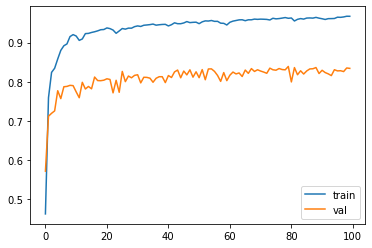

In [11]:
fig = plt.figure()
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.legend()

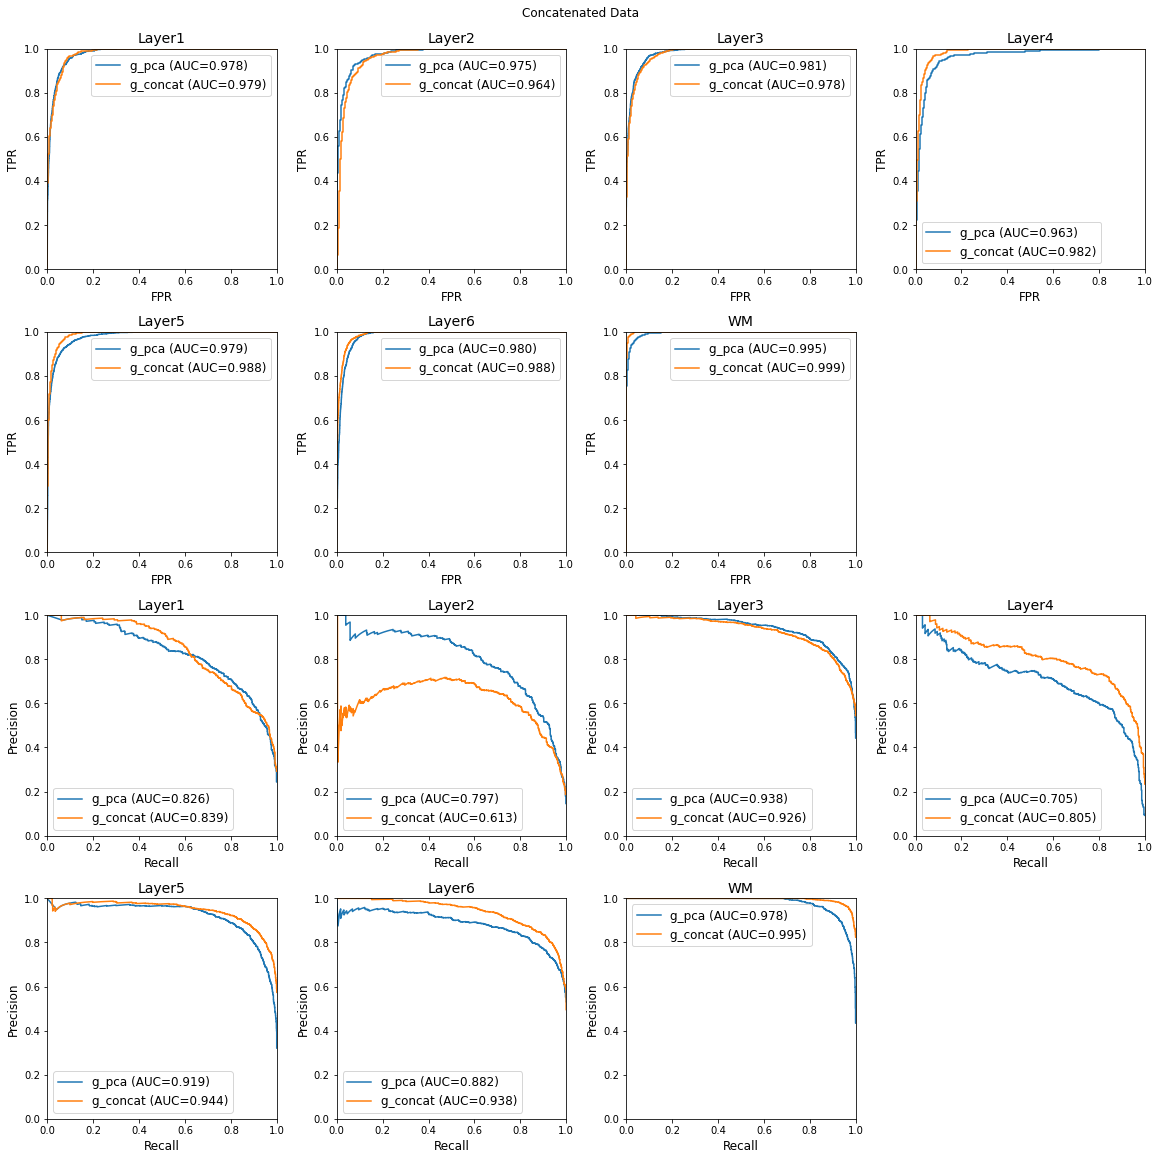

g_pca    - ACC: 0.815, MACRO_AUROC: 0.979, MACRO_AUPRC: 0.979
g_concat - ACC: 0.839, MACRO_AUROC: 0.983, MACRO_AUPRC: 0.866


In [13]:
# Compare performance of g_concat to g_pca

true, pred_concat, smax_concat = all_fgd_predictions(dataloader['val'], gnet_concat, f_only=False)

pcafiles_val = [os.path.join(data_dir, 'Countfiles_Visium_norm/%s_stdata_aligned_counts_IDs_PCs.tsv') % s for s in val_tissues]
pcadata_val = load_count_grid_dataset(pcafiles_val, annots_val)
_, pred_pca, smax_pca = all_fgd_predictions(DataLoader(pcadata_val, batch_size=1), gnet_pca, f_only=False)

fig, ax, macro_auroc, macro_auprc = performance_curves(true, [smax_pca, smax_concat], annot_names, ['g_pca','g_concat'])
fig.suptitle('Concatenated Data')
plt.show()

acc_pca = np.sum(pred_pca == true) / len(true)
acc_concat = np.sum(pred_concat == true) / len(true)

print('g_pca    - ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc_pca, macro_auroc[0], macro_auroc[0]))
print('g_concat - ACC: %.3f, MACRO_AUROC: %.3f, MACRO_AUPRC: %.3f' % (acc_concat, macro_auroc[1], macro_auprc[1]))